# Finding the invariant mass

## Captain log

> 160221 (Marie) 

> * Still need to understand the track loop, as it is it reads only the two track events
> * Some events with isCMUL==1 have none or more than 2 tracks, how to extract the invariant mass ? Need to implement other cuts, like nMuons==2, and sum the energies and impulsions for each muon

## Initialization

Libraries and root files.

> Be careful with the statistics and the runtime

Not enough statistic in run 290223 (3,7Mo)

Too much in runs 291375 (411Mo, runtime 3'), 291397 (891M, runtime 6', biggest file)

Prefer run 291690 (50.4Mo, runtime 21") to check the algorithm, 291944 (133Mo, runtime 54') to get a first idea with more statistics

> Decomment the one you want to download with curl

In [92]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt

In [93]:
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=290223/AnalysisResults.root' > run290223.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291397/AnalysisResults.root' > run291397.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291375/AnalysisResults.root' > run291375.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291944/AnalysisResults.root' > run291944.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291690/AnalysisResults.root' > run291690.data.root


In [94]:
file = uproot.open("run291690.data.root")
events = file["eventsTree"]

## Function declaration

On définit comme précédemment quelques fonctions pour calculer la pseudo-rapidité :

In [95]:
def mag(px:float,py:float,pz:float):
    """Returns the norm of the 3-vector (px,py,pz)."""
    return math.sqrt(px*px+py*py+pz*pz)

def costheta(px:float,py:float,pz:float):
    """Returns the cos(theta) of the 3 vector (px,py,pz)."""
    ptot = mag(px,py,pz)
    return 1.0 if ptot == 0.0 else pz/ptot

def eta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = costheta(px,py,pz)
    if ct*ct < 1:
        return -0.5* math.log( (1.0-ct)/(1.0+ct) )
    if pz == 0: 
        return 0
    if pz>0: 
        return 10E10
    else:
        return -10E20

## Invariant Mass

### Histograms

In [96]:
hMinv = hist.Hist(hist.axis.Regular(bins=10000,start=0,stop=1000,name='$Minv$'))

### Invariant Mass extraction

In [97]:
nofTracks=0 
nofEvents=0  
Emuneg = 0
Emupos = 0
Ppos = [0,0,0]
Pneg = [0,0,0]

for m in events.iterate(["nMuons","isCMUL","Muon_E","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.isCMUL>0]:
        nofEvents+=1
        tracks = event["Muon"].to_list()
        if len(tracks)==2:
            for t in tracks:
                nofTracks+=1
                if t["Charge"]<0:
                    Emuneg = t["E"]
                    Pneg = [t["Px"],t["Py"],t["Pz"]]
                if t["Charge"]>0:
                    Emupos = t["E"]
                    Ppos = [t["Px"],t["Py"],t["Pz"]]#
            Edimuon = Emuneg + Emupos
            Pdimuon = Ppos+Pneg
            magPdimuon = mag(Pdimuon[0],Pdimuon[1],Pdimuon[2])
            if np.sqrt(Edimuon*Edimuon - magPdimuon*magPdimuon) != 0:
                hMinv.fill(np.sqrt(Edimuon*Edimuon - magPdimuon*magPdimuon))

print(nofEvents,nofTracks)

121469 60258


### Plot

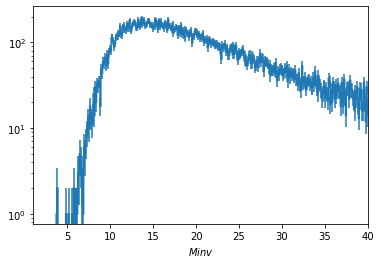

In [101]:
plt.yscale("log")
#plt.xscale("log")
plt.xlim(1,40)
hMinv.plot();